In [1]:
import torch_geometric as pyG
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F
import torch.nn as nn

# utils
import pandas as pd
from tqdm import tqdm
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
# load bike dataset from datasets folder
bike_data = pd.read_csv('datasets/MontrealBikeLane.csv')
# removing columns that have any missing data
bike_data = bike_data.dropna(axis=1)
bike_data

,Date,Time,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,11/11/2015,00:00,3044,1931,2828,1393,3603,1754,1142,2342,458,2328,3280,1210,338,1534,1527,2860,356
315,12/11/2015,00:00,1751,930,1670,888,2048,700,675,1566,152,1345,1877,755,180,960,955,1777,198
316,13/11/2015,00:00,1818,906,1711,873,2115,634,477,1522,150,1416,1980,719,204,978,1040,1727,258
317,14/11/2015,00:00,979,759,978,322,1112,290,310,601,98,1061,1448,269,70,640,805,737,73


In [3]:
# create dictionary with column names and index order starting from 0 excluding Date and Time
# this is because we want to predict the number of bikes in the future
# and we don't want to include the future in our features
node_encoder = {}
for i, col in enumerate(bike_data.columns):
    if col != 'Date' and col != 'Time':
        node_encoder[col] = i - 2
node_encoder

{'Berri1': 0,
 'Boyer': 1,
 'Brébeuf': 2,
 'CSC (Côte Sainte-Catherine)': 3,
 'Maisonneuve_2': 4,
 'Maisonneuve_3': 5,
 'Notre-Dame': 6,
 'Parc': 7,
 'PierDup': 8,
 'Rachel / Hôtel de Ville': 9,
 'Rachel / Papineau': 10,
 'René-Lévesque': 11,
 'Saint-Antoine': 12,
 'Saint-Urbain': 13,
 'Totem_Laurier': 14,
 'University': 15,
 'Viger': 16}

In [4]:
# open the BikeLanesConnections.txt and extract the connections between the nodes via links in the PyG format.
# Use the previous function of node enconder to transforms bike lanes name to the desired encoded format.
# Path: BikeLanesConnections.txt, format X <-> Y
# X and Y are the names of the bike lanes
# X <-> Y means that X and Y are connected
def get_edge_connections():
    with open('BikeLanesConnections.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [x.split(' <-> ') for x in content]
    content = [[node_encoder[x[0]], node_encoder[x[1]]] for x in content]
    content = torch.tensor(content).t().contiguous()
    return content

# create function to get edge and node index
def get_node_and_edge_index(bike_data):
    node_index = list(
        range(0, len(
                    [col for col in bike_data.columns if col not in ["Date", "Time"]]
                )
        )
    )
    
    edge_index = get_edge_connections()

    return node_index, edge_index

# create function to create a Data object in Pytorch Geometric for each row
def create_graph(row, edge_index):
    node_features = torch.tensor(
        row[[col for col in bike_data.columns if col not in ["Date", "Time"]]],
        dtype=torch.float
    ).view(-1, 1)
    return Data(x=node_features, edge_index=edge_index)

# showcasing one graph
node_index, edge_index = get_node_and_edge_index(bike_data)
graph = create_graph(bike_data.iloc[0], edge_index)
graph

Data(x=[17, 1], edge_index=[2, 27])

/var/folders/bj/dl04dyqj0zb3yqggq2_t15240000gn/T/ipykernel_18217/665288698.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


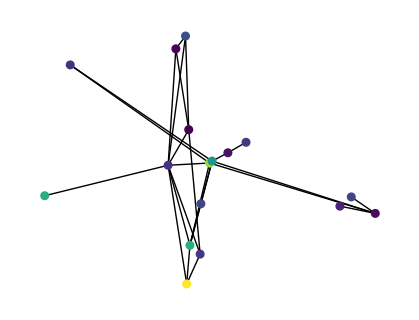

In [5]:
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.x.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(4, 3))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(graph, n_sample=17)
plot_graph(g, y)

In [6]:
class RandomNodeSplitter:
    def __init__(self, train_val_test_ratio = [0.8, 0.1, 0.1]):
        self.train_val_test_ratio = train_val_test_ratio
        self.has_mask = False
    

    def setup_split(self, num_nodes) -> None:
        num_nodes = graph.num_nodes
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        # randomly assign nodes to train, val, test with permutation
        train_ratio = self.train_val_test_ratio[0]
        train_n = int(num_nodes * train_ratio)
        val_ratio = self.train_val_test_ratio[1]
        val_n = int(num_nodes * val_ratio)

        permutation = torch.randperm(num_nodes)
        train_mask[permutation[:train_n]] = 1
        val_mask[permutation[train_n:train_n+val_n]] = 1
        test_mask[permutation[train_n+val_n:]] = 1

        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

        self.has_mask = True


    def __call__(self, graph, save_mask=True) -> pyG.data.data.Data:
        if self.has_mask is False or save_mask is False:
            print("Generating new random split.")
            self.setup_split(graph.num_nodes)

        # assign masks to graph
        graph.train_mask = self.train_mask
        graph.val_mask = self.val_mask
        graph.test_mask = self.test_mask

        return graph

split = RandomNodeSplitter()
graph = split(graph)
graph

Generating new random split.


Data(x=[17, 1], edge_index=[2, 27], train_mask=[17], val_mask=[17], test_mask=[17])

In [7]:
# using loader to get the full dataset but split into train, val, test
split = RandomNodeSplitter()
split.setup_split(graph.num_nodes)
data_list = [split(create_graph(row, edge_index)) for _, row in bike_data.iterrows()]
loader = DataLoader(data_list, batch_size=len(data_list), shuffle=False)
for dataset in loader:
    break
dataset

DataBatch(x=[5423, 1], edge_index=[2, 8613], train_mask=[5423], val_mask=[5423], test_mask=[5423], batch=[5423], ptr=[320])

In [42]:
def eval_node_regression(model, graph, mask):
    model.eval()
    pred = model(graph)
    return F.mse_loss(pred[mask], graph.x[mask])

def train_node_regression(model, graph, optimizer, criterion, n_epochs=200):
    pbar = tqdm(range(1, n_epochs + 1))
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.x[graph.train_mask])
        loss.backward()
        optimizer.step()

        reg_loss = eval_node_regression(model, graph, graph.val_mask)

        # use pbar to print loss every 1% of the training
        if epoch % (n_epochs // 100) == 0:
            pbar.set_description(f"Loss train: {loss.item():.4f}. Validation loss: {reg_loss:.4f}")

    return model


class GCN(torch.nn.Module):
    def __init__(self, num_node_features:int, dim_last_layer:int):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 1)
        self.conv2 = GCNConv(1, 1)
        self.conv3 = GCNConv(1, 1)
        self.fc1 = nn.Linear(1, dim_last_layer)

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) layer
        out = self.fc1(h)

        return out
    
device = "cpu"
graph = dataset[0]
gcn = GCN(dataset.num_features, 1)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.MSELoss()
gcn = train_node_regression(gcn, graph, optimizer_gcn, criterion, n_epochs=100000)

test_loss = eval_node_regression(gcn, graph, graph.test_mask)
print(f'Test loss: {test_loss:.3f}')

Loss train: 272.7650. Validation loss: 70.0010: 100%|██████████| 100000/100000 [01:15<00:00, 1324.35it/s]

Test loss: 2616.660


# GraphSAGE

In [7]:
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE

In [9]:
graph.edge_label

AttributeError: 'GlobalStorage' object has no attribute 'edge_label'

In [11]:
data = graph
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(data.num_node_features, hidden_channels=64,
                  num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)

train_loader = LinkNeighborLoader(
    data,
    batch_size=10,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[10, 10],
)


def train():
    model.train()

    total_loss = 0
    for batch in train_loader:
        print(batch)
        raise Exception
        batch = batch.to(device)
        optimizer.zero_grad()
        h = model(batch.x, batch.edge_index)
        h_src = h[batch.edge_label_index[0]]
        h_dst = h[batch.edge_label_index[1]]
        pred = (h_src * h_dst).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device)).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc


for epoch in range(1, 51):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'